Okay, time to rebuild our old statistical pipeline as best as we can. We will keep only the essential portions, in the interests of time and clarity.

## Contents

[Importing biom table and setup](#import)  


[Controls](#controls)
 - [Negative controls](#negC)

<a id='import'><h2>Importing biom table and setup</h2></a>

In [4]:
library('phyloseq')
library('DESeq2')
library('vegan')
library('cooccur')
library('igraph')
library('ecodist')
library('ade4')
library('png')

In [5]:
biom95 <- import_biom('combo_otu_wMeta.biom', parseFunction=parse_taxonomy_greengenes)

In [6]:
biom95

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11588 taxa and 232 samples ]
sample_data() Sample Data:       [ 232 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 11588 taxa by 7 taxonomic ranks ]

In [10]:
sample_data(biom95)

,vegcom,stream_distance,Host_genus,Host_genus_species,Library,Forest_Type,Host_species,X,Host_family,SorC,Y
100leaf,2,25.97654,Helicia,Helicia_formosana,L,7,formosana,183,Proteaceae,Sample,20
101leaf,3,18.36984,Helicia,Helicia_formosana,L,7,formosana,180,Proteaceae,Sample,27
102leaf,3,21.3725,Cleyera,Cleyera_japonica,L,7,japonica,187,Theaceae,Sample,27
103leaf,3,11.08831,Helicia,Helicia_formosana,L,7,formosana,180,Proteaceae,Sample,35
104leaf,3,1.409998,Helicia,Helicia_formosana,L,7,formosana,180,Proteaceae,Sample,51
105leaf,3,22.46722,Limlia,Limlia_uraiana,L,7,uraiana,180,Fagaceae,Sample,83
106leaf,2,82.49734,Helicia,Helicia_formosana,L,3,formosana,180,Proteaceae,Sample,147
107leaf,1,64.85876,Blastus,Blastus_cochinchinensis,L,3,cochinchinensis,307,Melastomataceae,Sample,147
108leaf,1,19.02113,Cleyera,Cleyera_japonica,L,3,japonica,243,Theaceae,Sample,83
109leaf,3,13.46815,Meliosma,Meliosma_squamulata,L,7,squamulata,209,Sabiaceae,Sample,49


<a id='controls'><h2>Controls</h3></a>

<a id='negC'><h3>Negative controls</h3></a>

In [14]:
neg95 <- subset_samples(biom95, sample_names(biom95)=='Neg')

In [15]:
neg95

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11588 taxa and 1 samples ]
sample_data() Sample Data:       [ 1 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 11588 taxa by 7 taxonomic ranks ]

How many reads are in our negative control?

In [16]:
sum(taxa_sums(neg95)[taxa_sums(neg95)>0])

[1] 1501

How many OTUs?

In [17]:
length(taxa_sums(neg95)[taxa_sums(neg95)>0])

[1] 43

Which OTUs, and what's their distribution?

In [19]:
taxa_sums(neg95)[taxa_sums(neg95)>0]

OTU167:Dc-X OTU187:Dc-PosG    OTU256:Dc-X    OTU762:Dc-X      OTU891:1w 
           469             85             35             53             58 
OTU306:Dc-PosG OTU119:Dc-PosG OTU220:Dc-PosG OTU164:Dc-PosG OTU235:Dc-PosG 
            96              1              1             51              1 
OTU386:Dc-PosG OTU264:Dc-PosG OTU560:Dc-PosG    OTU1183:36w       OTU64:1w 
            88              1             39              1              1 
     OTU409:4w      OTU417:1w      OTU437:1w       OTU18:9w     OTU414:13w 
             1             15              1              1              1 
     OTU655:1w     OTU2029:2w     OTU1432:2w    OTU1332:11w      OTU315:4w 
             1              1             28             44            162 
     OTU250:4w     OTU1599:9w     OTU2831:5w      OTU84:38w    OTU7329:38w 
             1              4              4             12              1 
   OTU2003:Neg    OTU925:133w     OTU1214:9w    OTU1747:11w   OTU1549:104w 
            42              1             53             53             28 
   OTU6852:Neg    OTU1496:23w     OTU588:32w    OTU1888:25w    OTU1444:49w 
            20              1              1              1             38 
     OTU46:60w    OTU972:130w   OTU2115:131w 
             3              1              2

To check for tag-switching, we'll look at our positive controls, or "mock-community" samples, for OTUs shared between the two controls. Such OTUs are good candidates for tag-switching. 

In [20]:
reads <- taxa_sums(neg95)[taxa_sums(neg95) > 0]
reads <- sort(reads, decreasing = TRUE)
sink('neg95names.txt') ## read out these OTUs so we can use them in python env
names(reads)
sink()

[1] "OTU167:Dc-X"    "OTU315:4w"      "OTU306:Dc-PosG" "OTU386:Dc-PosG"
 [5] "OTU187:Dc-PosG" "OTU891:1w"      "OTU762:Dc-X"    "OTU1214:9w"    
 [9] "OTU1747:11w"    "OTU164:Dc-PosG" "OTU1332:11w"    "OTU2003:Neg"   
[13] "OTU560:Dc-PosG" "OTU1444:49w"    "OTU256:Dc-X"    "OTU1432:2w"    
[17] "OTU1549:104w"   "OTU6852:Neg"    "OTU417:1w"      "OTU84:38w"     
[21] "OTU1599:9w"     "OTU2831:5w"     "OTU46:60w"      "OTU2115:131w"  
[25] "OTU119:Dc-PosG" "OTU220:Dc-PosG" "OTU235:Dc-PosG" "OTU264:Dc-PosG"
[29] "OTU1183:36w"    "OTU64:1w"       "OTU409:4w"      "OTU437:1w"     
[33] "OTU18:9w"       "OTU414:13w"     "OTU655:1w"      "OTU2029:2w"    
[37] "OTU250:4w"      "OTU7329:38w"    "OTU925:133w"    "OTU1496:23w"   
[41] "OTU588:32w"     "OTU1888:25w"    "OTU972:130w"

Clean up with sed. Back into BASH kernel:

In [1]:
## BASH
sed 's/\[.*\]//g' neg95names.txt |sed 's/^\s*//g' | sed 's/\s\+/,/g' | sed '$s/,$/\)/' | sed '1s/\"OTU/mcseq=\(\"OTU/' > neg95list.txt

Checked with vim, had to add a comma or two, not sure why. Anyway, its a a tuple. And the second half of the script:

In [11]:
cat MCseq.py


with open('otus_95_combo_nolb.fasta', 'r') as zoop:
        refseq = zoop.readlines()

with open('mcseq.txt', 'w') as goop:
        for j,otu in enumerate(mcseq):
                for i,line in enumerate(refseq):
                        if otu in line:
                                goop.write(line)
                                goop.write(refseq[i+1])




In [12]:
cat neg95list.txt MCseq.py > makeMCseq.py

In [13]:
cat makeMCseq.py

mcseq=("OTU167:Dc-X","OTU315:4w","OTU306:Dc-PosG","OTU386:Dc-PosG",
"OTU187:Dc-PosG","OTU891:1w","OTU762:Dc-X","OTU1214:9w",
"OTU1747:11w","OTU164:Dc-PosG","OTU1332:11w","OTU2003:Neg",
"OTU560:Dc-PosG","OTU1444:49w","OTU256:Dc-X","OTU1432:2w",
"OTU1549:104w","OTU6852:Neg","OTU417:1w","OTU84:38w",
"OTU1599:9w","OTU2831:5w","OTU46:60w","OTU2115:131w",
"OTU119:Dc-PosG","OTU220:Dc-PosG","OTU235:Dc-PosG","OTU264:Dc-PosG",
"OTU1183:36w","OTU64:1w","OTU409:4w","OTU437:1w",
"OTU18:9w","OTU414:13w","OTU655:1w","OTU2029:2w",
"OTU250:4w","OTU7329:38w","OTU925:133w","OTU1496:23w",
"OTU588:32w","OTU1888:25w","OTU972:130w")

with open('otus_95_combo_nolb.fasta', 'r') as zoop:
        refseq = zoop.readlines()

with open('mcseq.txt', 'w') as goop:
        for j,otu in enumerate(mcseq):
                for i,line in enumerate(refseq):
                        if otu in line:
                                goop.write(line)
                                goop.write(refseq[i+1])




In [14]:
## run this to get sequences of OTUs that are in our positive control:
python3 makeMCseq.py

Make a friendly link to our sanger sequences of full ITS region of our positive control cultures, and make a blastable database from them:

In [17]:
aa=$(find ~ -type f -name "BioI-6098_OConnor_34875.seq.txt")
ln -s $aa ./mcsanger.fasta

In [19]:
## make our searchable database of sanger positive control sequences for blast:
makeblastdb -in mcsanger.fasta -dbtype nucl -logfile dberrors.txt

Do our searches, with a couple of output formats:

In [20]:
blastn -query mockseqs_Neg95.fasta -db mcsanger.fasta -out mcblast_Neg95.txt -num_descriptions 3 -num_alignments 3
blastn -query mockseqs_Neg95.fasta -db mcsanger.fasta -out mcblast_Neg95.csv -outfmt 10 -max_target_seqs 1

sed '1 i\qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore' mcblast_Neg95.csv -i
sed 's/_ITS[1,4],/,/g' mcblast_Neg95.csv -i
sed 's/Sample//g' mcblast_Neg95.csv -i

This csv file can be imported as a dataframe into R:

In [1]:
## change kernel to R
library('phyloseq')
blast <- read.csv("mcblast_Neg95.csv", stringsAsFactors=FALSE)
blast

qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
OTU306:Dc-PosG,9,100.00,176,0,0,1,176,504,329,3e-92,326.0
OTU386:Dc-PosG,19,100.00,175,0,0,1,175,513,339,1e-91,324.0
OTU164:Dc-PosG,8,100.00,143,0,0,1,143,451,309,5e-74,265.0
OTU560:Dc-PosG,4,100.00,180,0,0,1,180,485,306,2e-94,333.0
OTU256:Dc-X,6,100.00,184,0,0,1,184,535,352,1e-96,340.0
OTU84:38w,9,100.00,31,0,0,27,57,530,500,1e-11,58.4
OTU1599:9w,1,90.22,92,8,1,37,128,459,369,6e-30,119.0
OTU119:Dc-PosG,1,99.31,144,1,0,1,144,434,291,7e-73,261.0
OTU220:Dc-PosG,22,100.00,168,0,0,1,168,512,345,8e-88,311.0
OTU235:Dc-PosG,20,100.00,217,0,0,1,217,605,389,6e-115,401.0


Get rid of the lower quality matches:

In [2]:
goodblast <- blast[blast$pident > 94 & blast$length > 90,]

Make some useful vectors and graph:

In [4]:
reads <- taxa_sums(neg95)[taxa_sums(neg95) > 0]
reads <- sort(reads, decreasing = TRUE)
Neg95.gen <- tax_table(neg95)[names(reads),6] ## genus, from initial tax assignments
Neg95.gen[is.na(Neg95.gen)] <- "NoID"
Neg95.species <- tax_table(neg95)[names(reads),7] ## species, from initial tax assignments
Neg95.species[is.na(Neg95.species)] <- "NoID"
member <- names(reads) %in% goodblast$qseqid ## membership in mock community (probably tag-switchers)
MC <- vector(length = length(reads)); MC[] <- 0 ## empty vector, for MC sample #, filled below

In [6]:
Neg95bar <- data.frame(reads, member, MC, Neg95.gen, Neg95.species, stringsAsFactors=FALSE) ## dataframe

##fill the mock community sample number by querying our csv from blast results

colnames(Neg95bar)[1] <- "reads"
for (i in 1:nrow(Neg95bar)){
        if (rownames(Neg95bar)[i] %in% goodblast$qseqid) {
                search <- grep(rownames(Neg95bar)[i], goodblast$qseqid)
                Neg95bar$MC[i] <- goodblast$sseqid[search]
        }
    }


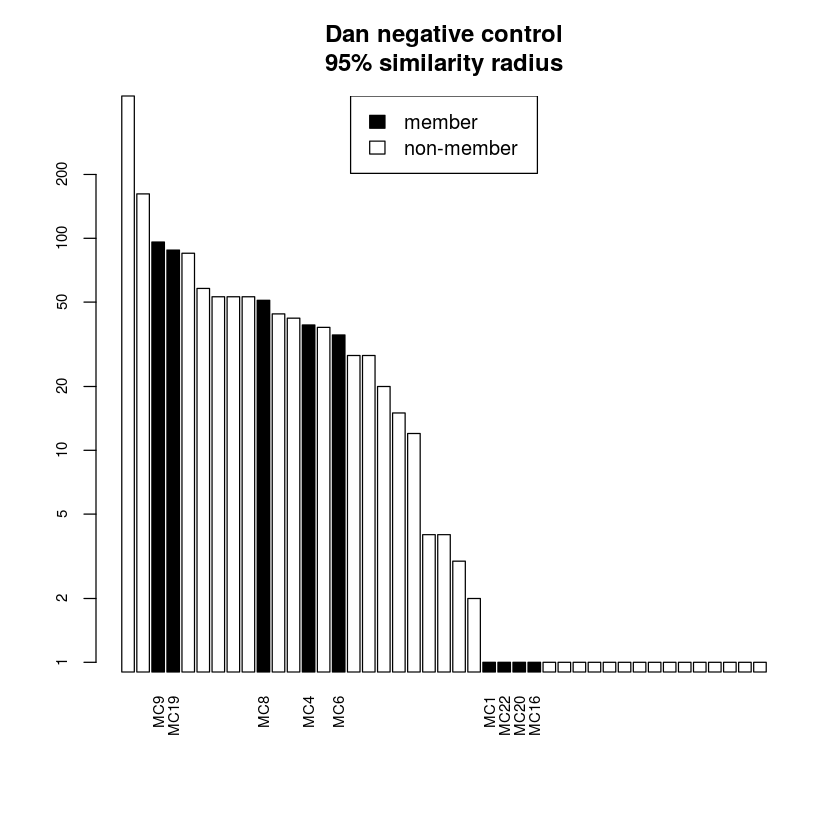

In [7]:
inout <- paste('MC', Neg95bar$MC, sep='')
inout[inout=='MC0'] <- NA

par(cex.axis = .75, mar=c(7,4,4,2))
barplot(Neg95bar$reads,las=3,log='y', names.arg=inout, col = member,
       main = 'Dan negative control\n95% similarity radius')
legend("top", legend=c('member','non-member'), fill=c(1,0))